# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"> **Air Quality** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Batch Inference</span>

## 🗒️ This notebook is divided into the following sections:

1. Download model and batch inference data
2. Make predictions, generate PNG for forecast
3. Store predictions in a monitoring feature group adn generate PNG for hindcast

## <span style='color:#ff5f27'> 📝 Imports

In [1]:
import sys
from pathlib import Path

def is_google_colab() -> bool:
    if "google.colab" in str(get_ipython()):
        return True
    return False

def clone_repository() -> None:
    !git clone https://github.com/featurestorebook/mlfs-book.git
    %cd mlfs-book

def install_dependencies() -> None:
    !pip install --upgrade uv
    !uv pip install --all-extras --system --requirement pyproject.toml


if is_google_colab():
    clone_repository()
    install_dependencies()
    root_dir = str(Path().absolute())
    print("Google Colab environment")
else:
    root_dir = Path().absolute()
    # Strip ~/notebooks/ccfraud from PYTHON_PATH if notebook started in one of these subdirectories
    if root_dir.parts[-1:] == ('airquality',):
        root_dir = Path(*root_dir.parts[:-1])
    if root_dir.parts[-1:] == ('notebooks',):
        root_dir = Path(*root_dir.parts[:-1])
    root_dir = str(root_dir) 
    print("Local environment")

# Add the root directory to the `PYTHONPATH` to use the `recsys` Python module from the notebook.
if root_dir not in sys.path:
    sys.path.append(root_dir)
print(f"Added the following directory to the PYTHONPATH: {root_dir}")
    
# Read the API keys and configuration variables from the file <root_dir>/.env
from mlfs import config
settings = config.HopsworksSettings(_env_file=f"{root_dir}/.env")

Local environment
Added the following directory to the PYTHONPATH: /Users/kcah/Documents/code-repo/air-quality-prediction
HopsworksSettings initialized!


In [2]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from mlfs.airquality import util
import os

In [3]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)
today

datetime.datetime(2025, 11, 18, 13, 31, 8, 173554)

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [5]:
project = hopsworks.login()
fs = project.get_feature_store() 

secrets = hopsworks.get_secrets_api()
location_str = secrets.get_secret("SENSOR_LOCATION_HELSINKI_JSON").value
locations = json.loads(location_str)
# Pick the first location object as the target, or modify as needed
location = locations[0]
country = location['country']
city = location['city']
street = location['street']

# Get unique streets from locations
if isinstance(locations, list):
    unique_streets = [loc['street'] for loc in locations]
else:
    unique_streets = [locations['street']]

print(f"Found {len(unique_streets)} street(s) to process:")
for i, street in enumerate(unique_streets, 1):
    print(f"  {i}. {street}")

2025-11-18 13:42:02,669 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-11-18 13:42:02,672 INFO: Initializing external client
2025-11-18 13:42:02,672 INFO: Base URL: https://c.app.hopsworks.ai:443


2025-11-18 13:42:04,080 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1279136
Found 4 street(s) to process:
  1. kluuvi
  2. kallio-2
  3. mannerheimintie
  4. vartiokyla-huivipolku


## <span style="color:#ff5f27;">🪝 Download models from Model Registry and Process Each Street</span>

In [6]:
mr = project.get_model_registry()

# retrieved_model = mr.get_model(
#     name="air_quality_helsinki_xgboost_model",
#     version=1,
# )

# fv = retrieved_model.get_feature_view()

# # Download the saved model artifacts to a local directory
# saved_model_dir = retrieved_model.download()

In [ ]:
# # Loading the XGBoost regressor model and label encoder from the saved model directory
# # retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
# retrieved_xgboost_model = XGBRegressor()

# retrieved_xgboost_model.load_model(saved_model_dir + "/model_helsinki.json")

# # Displaying the retrieved XGBoost regressor model
# retrieved_xgboost_model

XGBRegressor(base_score='3.0071064E1', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float', 'float',
                            'float', 'float', 'float'],
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## <span style="color:#ff5f27;">✨ Process Each Street Separately   </span>


In [7]:
# Get weather forecast data (shared across all streets in the same city)
weather_fg = fs.get_feature_group(
    name='weather_helsinki',
    version=1,
)
batch_data_all = weather_fg.filter(weather_fg.date >= today).read()
# Add empty lag columns for the model
batch_data_all['pm25_lag_1d'] = float('nan')
batch_data_all['pm25_lag_2d'] = float('nan')
batch_data_all['pm25_lag_3d'] = float('nan')
batch_data_all

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.00s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,rain_sum,city,pm25_lag_1d,pm25_lag_2d,pm25_lag_3d
0,2025-11-22 00:00:00+00:00,3.55,0.0,23.424908,223.754715,0.0,helsinki,NaN,NaN,NaN
1,2025-11-20 00:00:00+00:00,2.35,0.2,16.676977,166.263718,0.2,helsinki,NaN,NaN,NaN
2,2025-11-24 00:00:00+00:00,0.60,0.0,17.298738,77.988548,0.0,helsinki,NaN,NaN,NaN
3,2025-11-19 00:00:00+00:00,-3.30,0.0,7.145796,49.085716,0.0,helsinki,NaN,NaN,NaN
4,2025-11-27 00:00:00+00:00,-6.10,0.0,10.086427,34.824570,0.0,helsinki,NaN,NaN,NaN
5,2025-11-25 00:00:00+00:00,-2.85,0.0,15.077082,33.310646,0.0,helsinki,NaN,NaN,NaN
6,2025-11-26 00:00:00+00:00,-5.45,0.0,13.896187,16.557161,0.0,helsinki,NaN,NaN,NaN
7,2025-11-21 00:00:00+00:00,2.20,0.0,5.447788,352.405426,0.0,helsinki,NaN,NaN,NaN
8,2025-11-23 00:00:00+00:00,-5.10,0.0,6.989936,55.491425,0.0,helsinki,NaN,NaN,NaN
9,2025-11-28 00:00:00+00:00,-4.95,0.0,14.773164,43.025070,0.0,helsinki,NaN,NaN,NaN


### <span style="color:#ff5f27;">🤖 Process each street separately</span>


Processing street: kluuvi (model: air_quality_helsinki_xgboost_model_kluuvi)


Downloading: 0.000%|          | 0/552157 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/28023 elapsed<00:00 remaining<?

Generated 10 predictions for kluuvi 2 files)... DONE
                       date  predicted_pm25  street
3 2025-11-19 00:00:00+00:00       42.467052  kluuvi
1 2025-11-20 00:00:00+00:00       38.035076  kluuvi
7 2025-11-21 00:00:00+00:00       35.639900  kluuvi
0 2025-11-22 00:00:00+00:00       26.722229  kluuvi
8 2025-11-23 00:00:00+00:00       45.055454  kluuvi

Data info for kluuvi:
<class 'pandas.core.frame.DataFrame'>
Index: 10 entries, 3 to 9
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype                  
---  ------                       --------------  -----                  
 0   date                         10 non-null     datetime64[us, Etc/UTC]
 1   temperature_2m_mean          10 non-null     float32                
 2   precipitation_sum            10 non-null     float32                
 3   wind_speed_10m_max           10 non-null     float32                
 4   wind_direction_10m_dominant  10 non-null     float32              

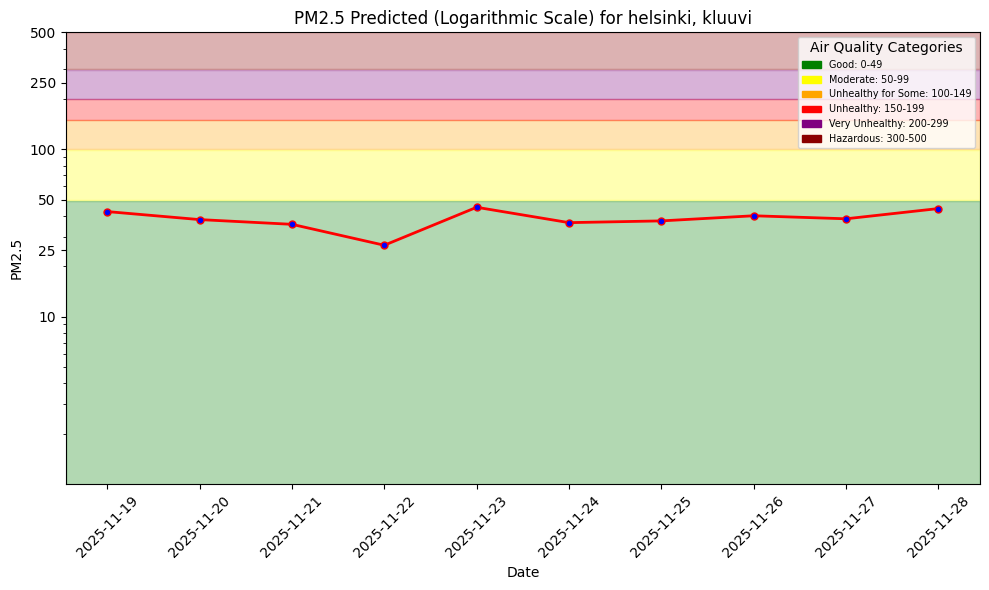

Uploading Dataframe: 100.00% |██████████| Rows 10/10 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: aq_predictions_helsinki_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1279136/jobs/named/aq_predictions_helsinki_1_offline_fg_materialization/executions
2025-11-18 13:44:59,837 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-18 13:45:03,043 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED


In [ ]:
# Get or create feature group (shared across all streets)
monitor_fg = fs.get_or_create_feature_group(
    name='aq_predictions_helsinki',
    description='Air Quality prediction monitoring',
    version=1,
    primary_key=['city','street','date','days_before_forecast_day'],
    event_time="date"
)

# Process each street separately
for street in unique_streets:
    street_safe = street.replace('-', '_')
    model_name = f"air_quality_helsinki_xgboost_model_{street_safe}"
    
    print(f"\n{'='*60}")
    print(f"Processing street: {street} (model: {model_name})")
    print(f"{'='*60}")
    
    # Get location info for this street
    if isinstance(locations, list):
        selected_location = next((loc for loc in locations if loc['street'] == street), None)
    else:
        selected_location = locations if locations['street'] == street else None
    
    if selected_location is None:
        print(f"Warning: Could not find location info for street {street}, skipping...")
        continue
    
    country = selected_location['country']
    city = selected_location['city']
    
    # Download the model for this street
    try:
        retrieved_model = mr.get_model(
            name=model_name,
            version=1,
        )
        saved_model_dir = retrieved_model.download()
    except Exception as e:
        print(f"Error loading model {model_name}: {e}")
        print(f"Skipping street {street}...")
        continue
    
    # Load the XGBoost model
    retrieved_xgboost_model = XGBRegressor()
    model_file = f"{saved_model_dir}/model_{street_safe}.json"
    if not os.path.exists(model_file):
        # Try alternative naming
        model_file = f"{saved_model_dir}/model_{street}.json"
    if not os.path.exists(model_file):
        # Try with city name
        model_file = f"{saved_model_dir}/model_helsinki.json"
    
    retrieved_xgboost_model.load_model(model_file)
    
    # Make a copy of batch data for this street
    batch_data = batch_data_all.copy()
    
    # Make predictions
    batch_data['predicted_pm25'] = retrieved_xgboost_model.predict(
        batch_data[['pm25_lag_1d', 'pm25_lag_2d', 'pm25_lag_3d', 'temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant', 'rain_sum']])
    
    # Add street, city, country columns
    batch_data['street'] = street
    batch_data['city'] = city
    batch_data['country'] = country
    batch_data['days_before_forecast_day'] = range(1, len(batch_data)+1)
    batch_data = batch_data.sort_values(by=['date'])
    
    print(f"Generated {len(batch_data)} predictions for {street}")
    print(batch_data[['date', 'predicted_pm25', 'street']].head())
    
    # Display info for this street
    print(f"\nData info for {street}:")
    batch_data.info()
    
    # Create forecast graph for this street
    street_safe_file = street.replace('-', '_')
    pred_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_forecast_{street_safe_file}.png"
    plt = util.plot_air_quality_forecast(city, street, batch_data, pred_file_path)
    plt.show()
    
    # Insert predictions for this street
    monitor_fg.insert(batch_data, wait=True)
    print(f"Inserted predictions for {street} into feature group")
    
    # We will create a hindcast chart for only the forecasts made 1 day beforehand for this street
    monitoring_df = monitor_fg.filter(
        (monitor_fg.days_before_forecast_day == 1) & 
        (monitor_fg.street == street)
    ).read()
    print(f"Hindcast data for {street}: {len(monitoring_df)} records")
    
    # Get air quality data for this street
    air_quality_fg = fs.get_feature_group(name='air_quality_lag', version=1)
    air_quality_df = air_quality_fg.filter(air_quality_fg.street == street).read()
    print(f"Air quality data for {street}: {len(air_quality_df)} records")
    
    outcome_df = air_quality_df[['date', 'pm25']]
    preds_df = monitoring_df[['date', 'predicted_pm25']]

    hindcast_df = pd.merge(preds_df, outcome_df, on="date")
    hindcast_df = hindcast_df.sort_values(by=['date'])

    # If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
    if len(hindcast_df) == 0:
        hindcast_df = util.backfill_predictions_for_monitoring(weather_fg, air_quality_df, monitor_fg, retrieved_xgboost_model)
    
    print(f"Hindcast data for {street}: {len(hindcast_df)} records")
    
    # Create hindcast graph for this street
    hindcast_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_hindcast_1day_{street_safe_file}.png"
    plt = util.plot_air_quality_forecast(city, street, hindcast_df, hindcast_file_path, hindcast=True)
    plt.show()
    
    # Upload images for this street
    dataset_api = project.get_dataset_api()
    str_today = today.strftime("%Y-%m-%d")
    if dataset_api.exists("Resources/airquality") == False:
        dataset_api.mkdir("Resources/airquality")
    dataset_api.upload(pred_file_path, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)
    dataset_api.upload(hindcast_file_path, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)
    
    print(f"Uploaded images for {street}")

# After processing all streets
proj_url = project.get_url()
print(f"\n{'='*60}")
print(f"Processing complete for all {len(unique_streets)} street(s)")
print(f"See images in Hopsworks here: {proj_url}/settings/fb/path/Resources/airquality")
print(f"{'='*60}")

In [ ]:
# All processing is done in the previous cell
# This cell is kept for any additional analysis if needed

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype                  
---  ------                       --------------  -----                  
 0   date                         10 non-null     datetime64[us, Etc/UTC]
 1   temperature_2m_mean          10 non-null     float32                
 2   precipitation_sum            10 non-null     float32                
 3   wind_speed_10m_max           10 non-null     float32                
 4   wind_direction_10m_dominant  10 non-null     float32                
 5   rain_sum                     10 non-null     float32                
 6   city                         10 non-null     object                 
 7   pm25_lag_1d                  0 non-null      float64                
 8   pm25_lag_2d                  0 non-null      float64                
 9   pm25_lag_3d                  0 non-null      float64                
 10  predi

### <span style="color:#ff5f27;">✅ Processing Complete</span>

All streets have been processed in the loop above. Each street:
- Has its own model loaded from the Model Registry
- Has predictions generated and stored in the monitoring feature group
- Has forecast and hindcast graphs generated
- Has images uploaded to Hopsworks

In [ ]:
# All processing completed in cell 13

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,rain_sum,city,pm25_lag_1d,pm25_lag_2d,pm25_lag_3d,predicted_pm25,street,country,days_before_forecast_day
3,2025-11-18 00:00:00+00:00,-2.10,0.0,11.269782,333.435028,0.00,helsinki,NaN,NaN,NaN,32.152294,kluuvi,finland,4
2,2025-11-19 00:00:00+00:00,-1.65,0.0,7.903619,59.931511,0.00,helsinki,NaN,NaN,NaN,43.254139,kluuvi,finland,3
1,2025-11-20 00:00:00+00:00,2.70,0.1,20.929596,183.945114,0.10,helsinki,NaN,NaN,NaN,35.246777,kluuvi,finland,2
4,2025-11-21 00:00:00+00:00,0.40,0.6,14.561099,351.469299,0.30,helsinki,NaN,NaN,NaN,26.227961,kluuvi,finland,5
0,2025-11-22 00:00:00+00:00,3.50,0.0,19.966211,244.359039,0.00,helsinki,NaN,NaN,NaN,23.207832,kluuvi,finland,1
5,2025-11-23 00:00:00+00:00,5.00,0.0,12.069400,197.354111,0.00,helsinki,NaN,NaN,NaN,33.997055,kluuvi,finland,6
6,2025-11-24 00:00:00+00:00,2.60,0.5,13.493999,189.210953,0.50,helsinki,NaN,NaN,NaN,31.445034,kluuvi,finland,7
8,2025-11-25 00:00:00+00:00,3.55,0.2,6.369050,317.290619,0.20,helsinki,NaN,NaN,NaN,34.506718,kluuvi,finland,9
9,2025-11-26 00:00:00+00:00,0.35,0.5,17.884428,40.100849,0.25,helsinki,NaN,NaN,NaN,33.819286,kluuvi,finland,10
7,2025-11-27 00:00:00+00:00,-0.25,0.1,14.973576,9.688724,0.00,helsinki,NaN,NaN,NaN,32.036186,kluuvi,finland,8


In [ ]:
# All processing completed in cell 13

<class 'pandas.core.frame.DataFrame'>
Index: 10 entries, 3 to 7
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype                  
---  ------                       --------------  -----                  
 0   date                         10 non-null     datetime64[us, Etc/UTC]
 1   temperature_2m_mean          10 non-null     float32                
 2   precipitation_sum            10 non-null     float32                
 3   wind_speed_10m_max           10 non-null     float32                
 4   wind_direction_10m_dominant  10 non-null     float32                
 5   rain_sum                     10 non-null     float32                
 6   city                         10 non-null     object                 
 7   pm25_lag_1d                  0 non-null      float64                
 8   pm25_lag_2d                  0 non-null      float64                
 9   pm25_lag_3d                  0 non-null      float64                
 10  predicted_

### 📊 Forecast and Hindcast Graphs

Forecast and hindcast graphs are generated for each street in the processing loop above.

2025-11-17 21:55:58,021 WARNING: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.



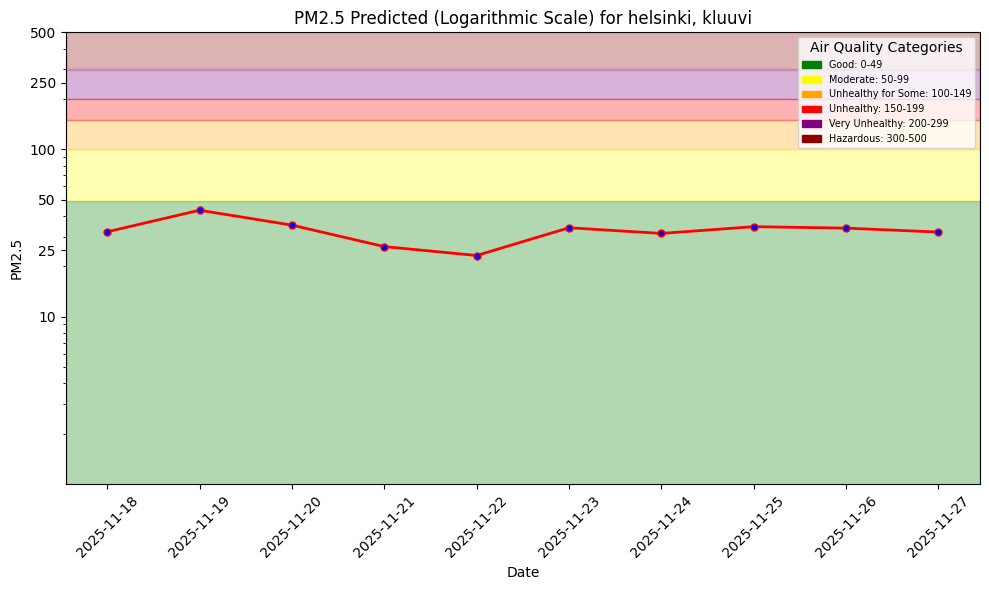

In [ ]:

# All processing completed in cell 13

In [ ]:
# # Get or create feature group
# monitor_fg = fs.get_or_create_feature_group(
#     name='aq_predictions_helsinki',
#     description='Air Quality prediction monitoring',
#     version=1,
#     primary_key=['city','street','date','days_before_forecast_day'],
#     event_time="date"
# )

In [ ]:
# monitor_fg.insert(batch_data, wait=True)

Uploading Dataframe: 100.00% |██████████| Rows 10/10 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: aq_predictions_helsinki_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1279136/jobs/named/aq_predictions_helsinki_1_offline_fg_materialization/executions
2025-11-17 21:56:15,171 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-17 21:56:18,338 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-17 21:58:22,637 INFO: Waiting for execution to finish. Current state: SUCCEEDING. Final status: UNDEFINED
2025-11-17 21:58:28,986 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-17 21:58:29,134 INFO: Waiting for log aggregation to finish.
2025-11-17 21:58:44,320 INFO: Execution finished successfully.


(Job('aq_predictions_helsinki_1_offline_fg_materialization', 'SPARK'), None)

In [ ]:
# # We will create a hindcast chart for  only the forecasts made 1 day beforehand
# monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()
# monitoring_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.54s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,rain_sum,city,pm25_lag_1d,pm25_lag_2d,pm25_lag_3d,predicted_pm25,street,country,days_before_forecast_day
0,2025-11-22 00:00:00+00:00,3.500000,0.0,19.966211,244.359039,0.0,helsinki,NaN,NaN,NaN,23.207832,kluuvi,finland,1
1,2025-11-15 00:00:00+00:00,2.078667,0.0,35.190346,280.367767,0.0,helsinki,18.0,25.0,37.0,18.528860,kluuvi,finland,1
2,2025-11-17 00:00:00+00:00,1.200000,0.0,6.569383,350.537750,0.0,helsinki,15.0,35.0,28.0,26.086435,kluuvi,finland,1
3,2025-11-16 00:00:00+00:00,5.649500,3.6,38.583031,246.212418,3.0,helsinki,29.0,17.0,21.0,22.580368,kluuvi,finland,1
4,2025-11-14 00:00:00+00:00,2.782833,0.2,23.899364,289.960083,0.1,helsinki,23.0,45.0,22.0,20.950607,kluuvi,finland,1


In [ ]:
# air_quality_fg = fs.get_feature_group(name='air_quality_lag', version=1)
# air_quality_df = air_quality_fg.read()
# air_quality_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.28s) 


,date,pm25,country,city,street,url,pm25_lag_1d,pm25_lag_2d,pm25_lag_3d
0,2021-06-01 00:00:00+00:00,30.0,finland,helsinki,kluuvi,https://api.waqi.info/feed/@5717,26.0,24.0,24.0
1,2024-11-24 00:00:00+00:00,19.0,finland,helsinki,kluuvi,https://api.waqi.info/feed/@5717,18.0,13.0,10.0
2,2025-04-09 00:00:00+00:00,21.0,finland,helsinki,kluuvi,https://api.waqi.info/feed/@5717,24.0,22.0,24.0
3,2024-02-25 00:00:00+00:00,27.0,finland,helsinki,kluuvi,https://api.waqi.info/feed/@5717,23.0,34.0,22.0
4,2016-12-04 00:00:00+00:00,20.0,finland,helsinki,kluuvi,https://api.waqi.info/feed/@5717,21.0,33.0,16.0
...,...,...,...,...,...,...,...,...,...
4166,2019-02-25 00:00:00+00:00,21.0,finland,helsinki,kluuvi,https://api.waqi.info/feed/@5717,21.0,18.0,32.0
4167,2016-06-27 00:00:00+00:00,37.0,finland,helsinki,kluuvi,https://api.waqi.info/feed/@5717,65.0,62.0,43.0
4168,2016-03-23 00:00:00+00:00,26.0,finland,helsinki,kluuvi,https://api.waqi.info/feed/@5717,39.0,20.0,16.0
4169,2018-10-03 00:00:00+00:00,21.0,finland,helsinki,kluuvi,https://api.waqi.info/feed/@5717,24.0,25.0,22.0


In [ ]:
# outcome_df = air_quality_df[['date', 'pm25']]
# preds_df =  monitoring_df[['date', 'predicted_pm25']]

# hindcast_df = pd.merge(preds_df, outcome_df, on="date")
# hindcast_df = hindcast_df.sort_values(by=['date'])

# # If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
# if len(hindcast_df) == 0:
#     hindcast_df = util.backfill_predictions_for_monitoring(weather_fg, air_quality_df, monitor_fg, retrieved_xgboost_model)
# hindcast_df

,date,predicted_pm25,pm25
3,2025-11-14 00:00:00+00:00,20.950607,13.0
0,2025-11-15 00:00:00+00:00,18.528860,13.0
2,2025-11-16 00:00:00+00:00,22.580368,9.0
1,2025-11-17 00:00:00+00:00,26.086435,18.0


### 📈 Hindcast Analysis

Hindcast graphs comparing predicted vs actual values are generated for each street in the processing loop above.

__Note: These graphs will be empty to begin with - this is normal.__

After a few days of predictions and observations, you will get data points in these graphs.

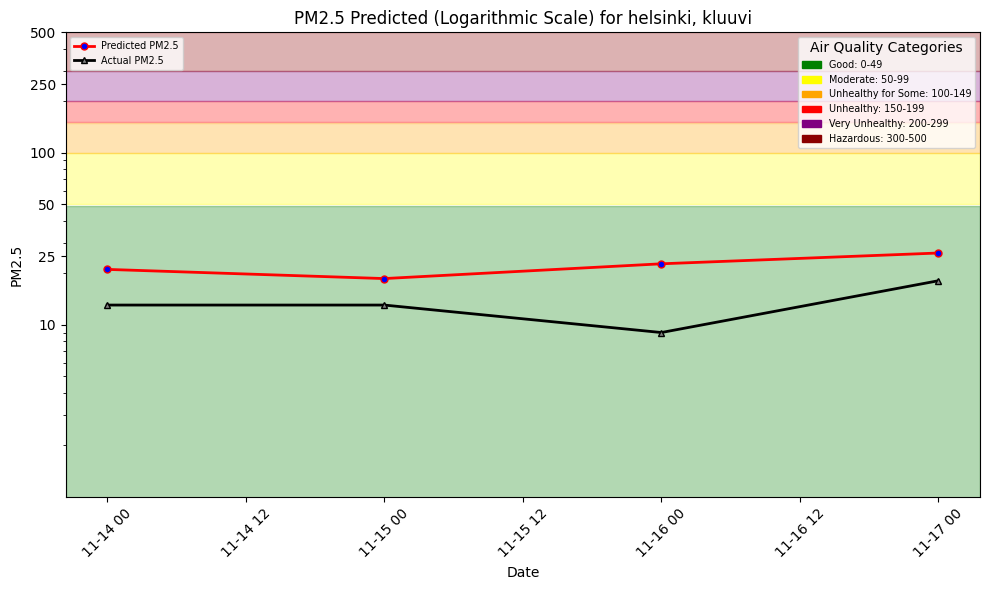

In [ ]:
# hindcast_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_hindcast_1day_helsinki.png"
# plt = util.plot_air_quality_forecast(city, street, hindcast_df, hindcast_file_path, hindcast=True)
# plt.show()

### ☁️ Image Uploads

Prediction and hindcast dashboard images (PNG files) are uploaded to Hopsworks for each street in the processing loop above.


In [ ]:
dataset_api = project.get_dataset_api()
str_today = today.strftime("%Y-%m-%d")
if dataset_api.exists("Resources/airquality") == False:
    dataset_api.mkdir("Resources/airquality")
dataset_api.upload(pred_file_path, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)
dataset_api.upload(hindcast_file_path, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)

proj_url = project.get_url()
print(f"See images in Hopsworks here: {proj_url}/settings/fb/path/Resources/airquality")

Uploading /Users/kcah/Documents/code-repo/air-quality-prediction/docs/air-quality/assets/img/pm25_forecast_hel…

Uploading /Users/kcah/Documents/code-repo/air-quality-prediction/docs/air-quality/assets/img/pm25_hindcast_1da…

See images in Hopsworks here: https://c.app.hopsworks.ai:443/p/1279136/settings/fb/path/Resources/airquality


---